## Checking weird data: ISSUES illustrated with 2017-03-01 data

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

In [2]:
import RunDailyEtapasBuilder

Enter the date to analyze: 2017-03-01
Enter the vehicle to analyze: BUS
Consider ZP in perfiles file (0/1)?: 0


In [3]:
etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
merged_df = RunDailyEtapasBuilder.mergeTurnstileData(etapas_df)
clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)
sorted_df = sorted_df.reset_index()

Not found in turnstile database: 1614656


* **1st ISSUE**: ADJACENT ROWS WITH SAME sitio_subida, SAME par_subida, SAME servicio_subida BUT CLEARLY DIFFERENT EXPEDITIONS. 
* **SEE BELOW FOR AN EXAMPLE (row 87029 - row 87030)**
* The solution to this would be to include id_expedicion from perfiles database. Currently, this solution is computationally expensive.

In [4]:
sorted_df[((sorted_df['par_subida']=='T-20-68-SN-23')&(sorted_df['servicio_subida']=='T536 00I')&(sorted_df['sitio_subida']=='BFKC-36'))]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion
86981,1582151,3167969406,4,BUS,2017-03-01 16:50:30,T536 00I,T-20-68-SN-23,BFKC-36,2017-05-02
87025,758948,1629661130,2,BUS,2017-03-01 21:46:46,T536 00I,T-20-68-SN-23,BFKC-36,2017-05-02
87026,1852337,3541945211,3,BUS,2017-03-01 21:46:55,T536 00I,T-20-68-SN-23,BFKC-36,2017-05-02
87027,2009097,3609059560,3,BUS,2017-03-01 21:46:57,T536 00I,T-20-68-SN-23,BFKC-36,2017-05-02
87028,1415182,2797037342,2,BUS,2017-03-01 21:47:00,T536 00I,T-20-68-SN-23,BFKC-36,2017-05-02
87029,928665,2131998184,2,BUS,2017-03-01 21:47:02,T536 00I,T-20-68-SN-23,BFKC-36,2017-05-02
87030,105057,55729378,2,BUS,2017-03-01 23:34:41,T536 00I,T-20-68-SN-23,BFKC-36,2017-05-02
87031,1737658,3323949982,2,BUS,2017-03-01 23:34:41,T536 00I,T-20-68-SN-23,BFKC-36,2017-05-02
87032,679232,1363181444,1,BUS,2017-03-01 23:34:44,T536 00I,T-20-68-SN-23,BFKC-36,2017-05-02
87033,279569,246728342,2,BUS,2017-03-01 23:34:45,T536 00I,T-20-68-SN-23,BFKC-36,2017-05-02


* Other example: row 88205 - row 88206

In [5]:
sorted_df[((sorted_df['par_subida']=='L-10-17-60-SN')&(sorted_df['servicio_subida']=='T531 00I')&(sorted_df['sitio_subida']=='BFKC-40'))]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion
88116,716408,1485613645,1,BUS,2017-03-01 07:12:16,T531 00I,L-10-17-60-SN,BFKC-40,2017-06-23
88156,165609,118885442,1,BUS,2017-03-01 08:10:19,T531 00I,L-10-17-60-SN,BFKC-40,2017-06-23
88157,1607487,3170065150,1,BUS,2017-03-01 08:10:27,T531 00I,L-10-17-60-SN,BFKC-40,2017-06-23
88190,397350,577775956,1,BUS,2017-03-01 10:05:34,T531 00I,L-10-17-60-SN,BFKC-40,2017-06-23
88204,1034405,2410944043,1,BUS,2017-03-01 10:57:34,T531 00I,L-10-17-60-SN,BFKC-40,2017-06-23
88205,880097,2014490944,1,BUS,2017-03-01 11:05:14,T531 00I,L-10-17-60-SN,BFKC-40,2017-06-23
88206,1559196,3136271182,1,BUS,2017-03-01 12:22:42,T531 00I,L-10-17-60-SN,BFKC-40,2017-06-23
88207,523100,930735979,1,BUS,2017-03-01 12:22:44,T531 00I,L-10-17-60-SN,BFKC-40,2017-06-23
88208,93833,52403314,1,BUS,2017-03-01 12:22:47,T531 00I,L-10-17-60-SN,BFKC-40,2017-06-23


* **2nd ISSUE**: ADJACENT ROWS WITH SAME sitio_subida, SAME par_subida, SAME servicio_subida AND ORIGINAL METHODOLOGY PROBLEMS
* **SEE BELOW FOR AN EXAMPLE (row 12425 - row 12426)**
* CURRENTLY THERE ARE NO SOLUTIONS TO THESE CASES

In [6]:
sorted_df.iloc[12423:12428]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion
12423,1120301,2504471726,1,BUS,2017-03-01 09:59:27,T429 00R,L-18-18-60-NS,BBZX-45,NaT
12424,1390158,2783321502,1,BUS,2017-03-01 10:00:35,T429 00R,L-18-18-60-NS,BBZX-45,NaT
12425,1902370,3562773982,1,BUS,2017-03-01 10:05:31,T429 00R,T-32-316-OP-30,BBZX-45,NaT
12426,48060,28537122,1,BUS,2017-03-01 10:16:20,T429 00R,T-32-316-OP-30,BBZX-45,NaT
12427,1118297,2504268414,1,BUS,2017-03-01 10:16:23,T429 00R,T-32-316-OP-30,BBZX-45,NaT


* Other example: row 36277 - row 3627

In [7]:
sorted_df.iloc[36274:36281]

,index,id,nviaje,tipo_transporte,t_subida,servicio_subida,par_subida,sitio_subida,fecha_instalacion
36274,1430140,2802288318,2,BUS,2017-03-01 14:18:03,T514 00I,T-20-182-PO-45,BDXR-43,NaT
36275,1806394,3494973324,3,BUS,2017-03-01 14:18:13,T514 00I,T-20-182-PO-45,BDXR-43,NaT
36276,2177733,3952864331,2,BUS,2017-03-01 14:18:17,T514 00I,T-20-182-PO-45,BDXR-43,NaT
36277,859669,1933468318,3,BUS,2017-03-01 14:18:22,T514 00I,T-20-182-PO-45,BDXR-43,NaT
36278,1817690,3517654248,3,BUS,2017-03-01 14:28:26,T514 00I,T-20-182-PO-45,BDXR-43,NaT
36279,1220655,2537409998,2,BUS,2017-03-01 14:28:28,T514 00I,T-20-182-PO-45,BDXR-43,NaT
36280,36733,27441474,1,BUS,2017-03-01 14:28:29,T514 00I,T-20-182-PO-45,BDXR-43,NaT


* Adding necessary attributes to further analyses

In [8]:
sorted_df['mismo_paradero'] = (sorted_df['par_subida']==sorted_df['par_subida'].shift()).fillna(False)
sorted_df['misma_patente'] = (sorted_df['sitio_subida']==sorted_df['sitio_subida'].shift()).fillna(False)
sorted_df['mismo_servicio'] = (sorted_df['servicio_subida']==sorted_df['servicio_subida'].shift()).fillna(False)
    
sorted_df.loc[(sorted_df.mismo_servicio == True) & (sorted_df.mismo_paradero == True) & (sorted_df.misma_patente == True), 'diferencia_tiempo'] = (sorted_df['t_subida']-sorted_df['t_subida'].shift())

sorted_df['diferencia_tiempo_secs'] = sorted_df['diferencia_tiempo'].dt.total_seconds()
sorted_df['fecha_instalacion'] = pd.to_datetime(sorted_df.fecha_instalacion)
sorted_df['si_torniquete'] = (sorted_df['fecha_instalacion']<=sorted_df['t_subida'])

In [9]:
time_keys = []
counts_problematic=[]
threshold = 60

not_nan_sorted_df = sorted_df.dropna(subset=['diferencia_tiempo'])
del sorted_df

total_count = not_nan_sorted_df.count()[0]
total_problematic_count = not_nan_sorted_df[not_nan_sorted_df['diferencia_tiempo_secs']<=threshold].count()[0]

percent = (total_problematic_count/total_count)*100

print('The total number of observations (without NaN) is: ' + str(total_count))
print('The total number of observation below ' + str(threshold) + ' seconds is ' + str(total_problematic_count))
print('The percent of observations below ' + str(threshold) + ' seconds is ' + str(percent))

The total number of observations (without NaN) is: 1380484
The total number of observation below 60 seconds is 1356598
The percent of observations below 60 seconds is 98.2697372805


In [10]:
for i in range(0,threshold):
    time_keys.append(i)
    counts_problematic.append(not_nan_sorted_df[not_nan_sorted_df['diferencia_tiempo_secs']>i].count()[0])

* Plot total data below a threshold

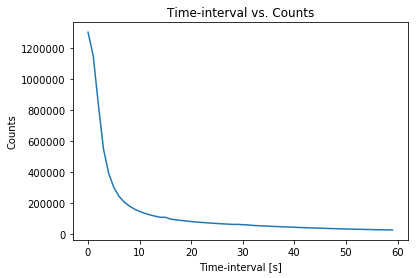

In [11]:
fig, ax = plt.subplots()
plot1 = ax.plot(time_keys,counts_problematic)
ax.set_title('Time-interval vs. Counts')
ax.set_xlabel('Time-interval [s]')
ax.set_ylabel('Counts')

### Closed